In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import FittingWorkCleaner as FWC
import Neutrino_Work as NW
from classy import Class

In [2]:
data_1= np.load("mass-300-life-0.030.npz", allow_pickle=True)
f_actual = data_1['fe'][-1]
e_actual = data_1['e'][-1]
Neff_short = data_1['neff']

data_2= np.load("mass-300-life-0.584.npz", allow_pickle=True)
f_actual_2 = data_2['fe'][-1]
e_actual_2 = data_2['e'][-1]
Neff_long = data_2['neff']


data_file = np.load("test-fit.npz", allow_pickle=True)
e = data_file['eps']
f = data_file['fe']


data_file2 = np.load("test-fit2.npz", allow_pickle=True)
e2 = data_file2['eps']
f2 = data_file2['fe']

In [3]:
FWC.finale(e_actual_2,f_actual_2,4,False)

(1.2335436064249623,
 0.6850939103999747,
 array([ 1.14347633e-09, -1.60098091e-06,  6.68093687e-04, -1.56469746e-01,
        -6.86539040e+00]))

In [108]:
def larger_emax(filename,alpha_num):
    alpha = alpha_num
    
    data_actual = np.load(filename, allow_pickle=True)
    f = data_actual['fe'][-1]
    e = data_actual['e'][-1]
    
    af = data_actual['scalefactors'][-1]
    tf = data_actual['temp'][-1]
    value = 1/(af*tf) 
    
    T,N,coefficients = FWC.finale(e,f,4,False)
    A,B,C,D,E = coefficients[0],coefficients[1],coefficients[2],coefficients[3],coefficients[4]
    
    T_p = T/alpha
    N_p = N
    A_p = A*(alpha)**4
    B_p = B*(alpha)**3
    C_p = C*(alpha)**2
    D_p = D*(alpha)**1
    E_p = E
    value_p = value*alpha
    
    k = len(e)-15
    e_shorter = np.delete(e,np.s_[-k:])
    
    dn = np.zeros(len(e_shorter))
    for i in range(len(e_shorter)):
        dn[i] = (value)**3*(2/(2*np.pi)**3)*(((N/np.exp(e_shorter[i]/T))+1)+np.exp(A*e_shorter[i]**4+B*e_shorter[i]**3+C*e_shorter[i]**2+D*e_shorter[i]+E))*4*(np.pi)**2*(e_shorter[i])**2
        
    
    k_p = len(e)-30
    e_p = np.delete(e,np.s_[-k_p:])
    
    dn_p = np.zeros(len(e_p))
    for i in range(len(e_p)):
        dn_p[i] = (value_p)**3*(2/(2*np.pi)**3)*(((N_p/np.exp(e_p[i]/T_p))+1)+np.exp(A_p*e_p[i]**4+B_p*e_p[i]**3+C_p*e_p[i]**2+D_p*e_p[i]+E_p))*4*(np.pi)**2*(e_p[i])**2
        
    F_p = np.zeros(len(e_p))
    for i in range(len(e_p)):
        F_p[i] = (2/(2*np.pi)**3)*(((N_p/np.exp(e_p[i]/T_p))+1)+np.exp(A_p*e_p[i]**4+B_p*e_p[i]**3+C_p*e_p[i]**2+D_p*e_p[i]+E_p))
        
    plt.figure()
    plt.plot(e_shorter,dn,color="blue")
    plt.plot(e_p,dn_p,color='red')
    plt.show
    
    
    plt.figure()
    plt.plot(alpha*e_p,F_p,color='black')
    plt.show
    
    
    
    
    

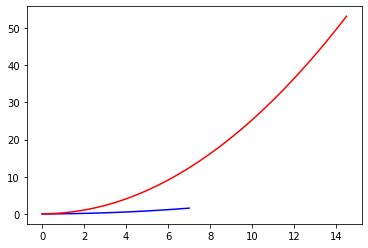

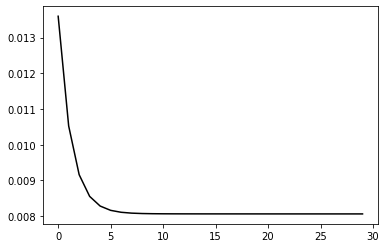

In [109]:
larger_emax("mass-300-life-0.584.npz",2)

In [142]:
T,N,coeff = FWC.finale(e_actual_2,f_actual_2,4,False)  
A,B,C,D,E = coeff[0],coeff[1],coeff[2],coeff[3],coeff[4]
af = data_1['scalefactors'][-1]
tf = data_1['temp'][-1]
T_ncdm = 1/(af*tf) 
k = len(e_actual_2)-30
e_shorter = np.delete(e_actual_2,np.s_[-k:])
f_shorter = np.delete(f_actual_2,np.s_[-k:])
print(A)


1.1434763286060605e-09


In [132]:
def mimic(e,T,N,A,B,C,D,E,T_ncdm):
    dn = np.zeros(len(e))
    for i in range(len(e)):
        dn[i] = (T_ncdm)**3*(2/(2*np.pi)**3)*(((N/np.exp(e[i]/T))+1)+np.exp(A*e[i]**4+B*e[i]**3+C*e[i]**2+D*e[i]+E))*4*(np.pi)**2
    return dn 

    
    

In [133]:
mimic(e_shorter,T,N,A,B,C,D,E,T_ncdm)

array([0.11976202, 0.10354048, 0.09272331, 0.08550963, 0.08069868,
       0.07748986, 0.07534935, 0.0739212 , 0.07296811, 0.07233183,
       0.07190684, 0.07162278, 0.07143275, 0.07130545, 0.07122003,
       0.07116257, 0.07112378, 0.07109749, 0.07107956, 0.07106723,
       0.07105866, 0.07105263, 0.07104831, 0.07104515, 0.07104279,
       0.07104098, 0.07103955, 0.07103839, 0.07103743, 0.07103661])

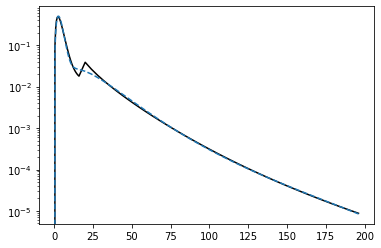

(1.2335436064249623,
 0.6850939103999747,
 array([ 1.14347633e-09, -1.60098091e-06,  6.68093687e-04, -1.56469746e-01,
        -6.86539040e+00]))

In [135]:
FWC.finale(e_actual_2,f_actual_2,4,True)

/Users/charmquark/Downloads/M_nu_sterile_decay/FittingWorkCleaner.py:90: RuntimeWarning: overflow encountered in exp
  diff_reverse[i] = (f_array_reverse[i])-((Nbest)/(np.exp(e_array_reverse[i]/Tbest)+1))
/Users/charmquark/Downloads/M_nu_sterile_decay/FittingWorkCleaner.py:117: RuntimeWarning: overflow encountered in exp
  plt.semilogy(e_array,N_best*(e_array**2)/(np.exp(e_array/T_best)+1)+e_array**2*np.exp(polynomial(e_array)),linestyle='--')


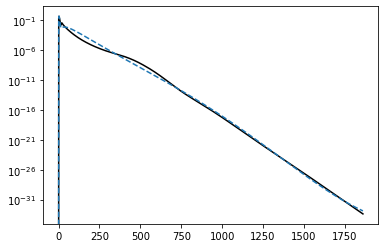

(1.2335436064249623,
 0.6850939103999747,
 array([ 9.94195555e-12, -3.80535518e-08,  4.56298843e-05, -6.06696231e-02,
        -9.86733677e+00]))

In [140]:
FWC.finale_no_cdf(e_actual_2,f_actual_2,4,True)